# XDMoD Data Analytics Framework — User Resource Overlaps
v1.0.0

© 2023 University at Buffalo Center for Computational Research

See the [xdmod-notebooks](https://github.com/ubccr/xdmod-notebooks) repository for licensing information.

## Introduction
The XDMoD Data Analytics Framework provides API access to the data in XDMoD via the [`xdmod_data` Python module](https://pypi.org/project/xdmod-data). This notebook provides an introductory example showing how to use the module. You will use the XDMoD API to request data, load them into a [Pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), and generate plots. The dataset in this example contains the number of active users of [ACCESS](https://access-ci.org/)-allocated resources per day of the week over a 4-month period.

## Install/upgrade the required modules
Run the code below to install/upgrade the modules needed to run this notebook.

In [ ]:
import sys
! {sys.executable} -m pip install --upgrade xdmod-data python-dotenv tabulate

import pandas as pd

If running that code caused a new version of Plotly to be installed/upgraded, you may need to refresh your browser window for plots to appear correctly.

## Configure notebook formatting

### Tables
Run the code below to set up for displaying Pandas DataFrames as Markdown tables in this notebook.

In [ ]:
from IPython.display import display, Markdown
def display_df_md_table(df):
    return display(Markdown(df.replace('\n', '<br/>', regex=True).to_markdown()))

## Plotting
Run the code below to import plotly libraries and set the XDMoD theme

In [ ]:
import plotly.express as px
import plotly.io as pio
import xdmod_data.themes
pio.templates.default = "timeseries"

## Create an environment file
The `xdmod-data.env` file will store your XDMoD API token.

Run the code below to create the file in your home directory (if it does not already exist) and allow only you to read and write to it.

In [ ]:
from pathlib import Path
from os.path import expanduser
xdmod_data_env_path = Path(expanduser('~/xdmod-data.env'))
try:
    with open(xdmod_data_env_path):
        pass
except FileNotFoundError:
    with open(xdmod_data_env_path, 'w') as xdmod_data_env_file:
        xdmod_data_env_file.write('XDMOD_API_TOKEN=')
    xdmod_data_env_path.chmod(0o600)

## Obtain an API token
Follow [these instructions](https://github.com/ubccr/xdmod-data#api-token-access) to obtain an API token.

## Store your API token in the environment file
Open the `xdmod-data.env` file and paste your token after `XDMOD_API_TOKEN=`.

Save the file.

## Load your XDMoD API token into the environment
Run the code below to load the contents of the `xdmod-data.env` file into the environment. It will print `True` if it successfully loaded the file.

In [ ]:
from dotenv import load_dotenv
load_dotenv(xdmod_data_env_path, override=True)

## Initialize the XDMoD Data Warehouse
Run the code below to prepare for getting data from the XDMoD data warehouse at the given URL.

In [ ]:
from xdmod_data.warehouse import DataWarehouse
dw = DataWarehouse('https://xdmod.access-ci.org')

## Get the list of resource that have run compute jobs

Get the list of compute resources that have run compute jobs during the specific times and how many distinct ACCESS users have used it.

In [ ]:
report_start = '2022-10-01'
report_end = '2023-09-30'

with dw:
    resources = dw.get_data(
        duration=(report_start, report_end),
        realm='Jobs',
        metric='Number of Users: Active',
        dataset_type='aggregate',
        dimension='Resource'
    )

Then for each resource we can obtain the list of users and the number of service units consumed during the report period. In this case we just stored the list of users for each resource.

In [ ]:
resource_people = {}
for resource in resources.index:
    with dw: 
        people = dw.get_data(
            duration=(report_start, report_end),
            realm='Jobs',
            metric='ACCESS Credit Equivalents Charged: Total (SU)',
            dataset_type='aggregate',
            dimension='User',
            filters={
                'Resource': [resource]
            }
        )
        resource_people[resource] = set(people.index)



Then compute the overlap of users between different resources and display in a table.

In [ ]:
out = {'Resource': []}
for r1, r1p in resource_people.items():
    out['Resource'].append(r1)
    for r2, r2p in resource_people.items():
        if r2 not in out:
            out[r2] = []
        out[r2].append(len(r1p.intersection(r2p)))
        
data = pd.DataFrame(out)

In [ ]:
data

In [ ]:
from IPython.display import Javascript
js_download = """
var csv = `%s`;

var filename = 'User-Resource-Overlap.csv';
var blob = new Blob([csv], { type: 'text/csv;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    link.innerHTML = 'Download as CSV';
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        document.body.appendChild(link);
    }
}
""" % data.to_csv(index=False)

# Note this javascript link is intended for use when you export the notebook to html
# via jupyter nbconvert --to html [NOTEBOOK]
Javascript(js_download)

In [ ]:
allpeople = set()
for r, p in resource_people.items():
    allpeople |= p
    
out = {'Person': list(allpeople), 'Resource Count': []}
for p in out['Person']:
    count = 0
    for pet in resource_people.values():
        if p in pet:
            count += 1
    out['Resource Count'].append(count)

data = pd.DataFrame(out)

In [ ]:
fig = px.histogram(data, x='Resource Count', log_y=True, text_auto=True)
fig.update_layout(yaxis_title="Number of Users (log scale)")
fig.show()

---
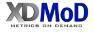 XDMoD Data Analytics Framework v1.0.0